# Importing Libraries

In [1]:
#Basic Mathematics and data manipulation libraries
import numpy as np
import pandas as pd

#Librarires for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#System libraries
from tqdm import tqdm
import os
import sys

#Image processing libraries
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CNN libraries
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Data Handling libraries
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Evaluation libraries
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score
from sklearn import metrics

#Local python files
from Functions import callbacks,accuracy,prediction, confusion, train, layers

import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Data Preperation

In [2]:
labels = ['glioma_tumor','meningioma_tumor','pituitary_tumor','no_tumor'] 

X = []
y = []
img_size = 150
for a in labels:
    path_ = os.path.join('brain_tumor/Training',a)
    for b in tqdm(os.listdir(path_)):
        pics = cv2.imread(os.path.join(path_,b))
        pics = cv2.resize(pics,(img_size, img_size))
        X.append(pics)
        y.append(a)
        
for a in labels:
    path_ = os.path.join('brain_tumor/Testing',a)
    for b in tqdm(os.listdir(path_)):
        pics = cv2.imread(os.path.join(path_,b))
        pics = cv2.resize(pics,(img_size,img_size))
        X.append(pics)
        y.append(a)
        
X = np.array(X)
y = np.array(y)

100%|██████████| 105/105 [00:00<00:00, 454.41it/s]


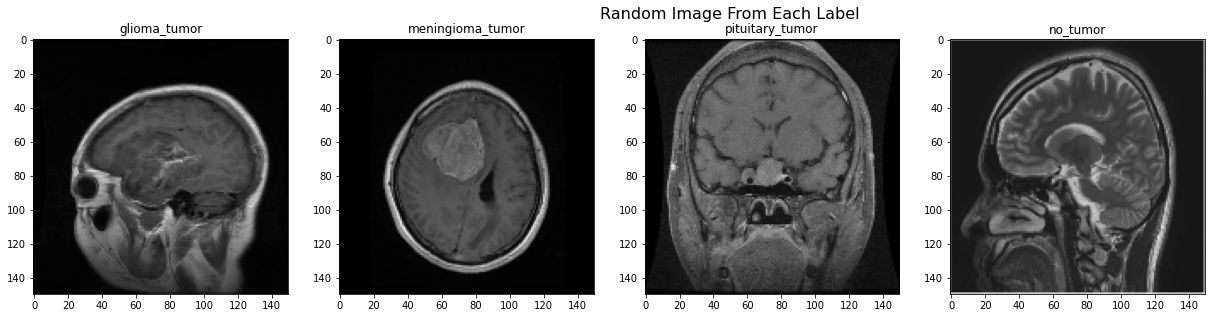

In [3]:
c=0
fig, ax = plt.subplots(1,4,figsize=(21,21))
fig.text(s='Random Image From Each Label',size=16,y=0.6,x=0.5)
for a in labels:
    b=44
    while True :
        if y[b]==a:
            ax[c].imshow(X[b])
            ax[c].set_title(y[b])
            c=c+1
            break
        b=b+11

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=1, shuffle=True)

In [5]:
y_train_one = []
for x in y_train:
    y_train_one.append(labels.index(x))
y_train = y_train_one
y_train = tf.keras.utils.to_categorical(y_train)

y_test_one = []
for x in y_test:
    y_test_one.append(labels.index(x))
y_test = y_test_one
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

## VGG-16

In [6]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

In [7]:
model_v=layers(pretrained_model=vgg)

In [8]:
model_v.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 3.0917 - accuracy: 0.2732
Epoch 00001: val_accuracy improved from -inf to 0.27891, saving model to VGG.h5
83/83 [==============================] - 328s 4s/step - loss: 3.0917 - accuracy: 0.2732 - val_loss: 1.3810 - val_accuracy: 0.2789
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 1.3495 - accuracy: 0.3205
Epoch 00002: val_accuracy improved from 0.27891 to 0.35714, saving model to VGG.h5
83/83 [==============================] - 328s 4s/step - loss: 1.3495 - accuracy: 0.3205 - val_loss: 1.2774 - val_accuracy: 0.3571
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 1.2515 - accuracy: 0.4196
Epoch 00003: val_accuracy improved from 0.35714 to 0.37755, saving model to VGG.h5
83/83 [==============================] - 338s 4s/step - loss: 1.2515 - accuracy: 0.4196 - val_loss: 1.2279 - val_accuracy: 0.3776
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 1.1937 - a

/user/HS400/sp01570/Desktop/Dissertation/Functions.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.86      0.88       101
meningioma_tumor       0.90      0.89      0.89        97
 pituitary_tumor       0.95      0.98      0.96        84
        no_tumor       0.88      0.96      0.91        45

        accuracy                           0.91       327
       macro avg       0.91      0.92      0.91       327
    weighted avg       0.91      0.91      0.91       327



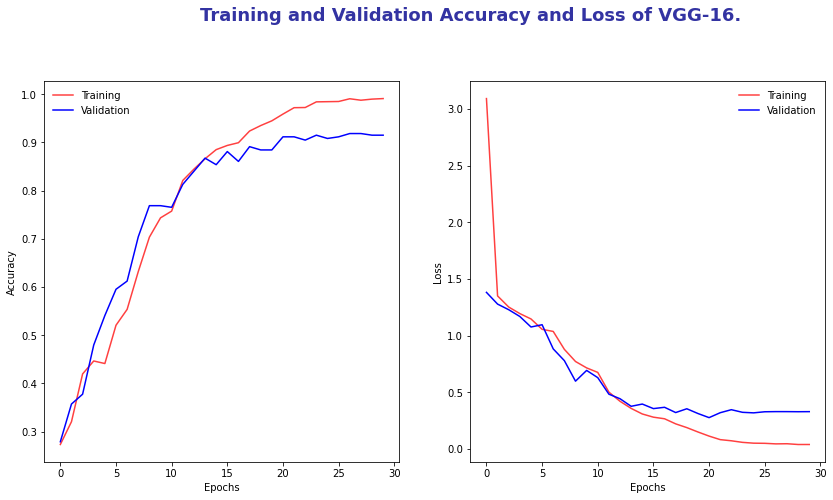

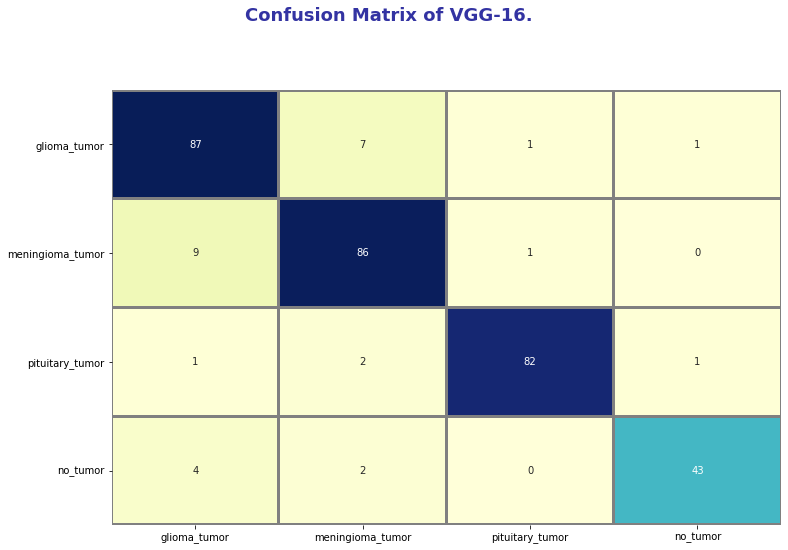

In [9]:
train(model_name=model_v,save_name='VGG.h5',epoch=100,name='VGG-16',X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)

## ResNet

In [10]:
res = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

In [11]:
model_r=layers(pretrained_model=res)

In [12]:
model_r.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8494
Epoch 00001: val_accuracy improved from -inf to 0.43878, saving model to ResNet.h5
83/83 [==============================] - 182s 2s/step - loss: 0.4475 - accuracy: 0.8494 - val_loss: 18.6979 - val_accuracy: 0.4388
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9414
Epoch 00002: val_accuracy improved from 0.43878 to 0.48299, saving model to ResNet.h5
83/83 [==============================] - 180s 2s/step - loss: 0.1834 - accuracy: 0.9414 - val_loss: 4.2157 - val_accuracy: 0.4830
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9546
Epoch 00003: val_accuracy improved from 0.48299 to 0.91156, saving model to ResNet.h5
83/83 [==============================] - 179s 2s/step - loss: 0.1618 - accuracy: 0.9546 - val_loss: 0.3477 - val_accuracy: 0.9116
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 

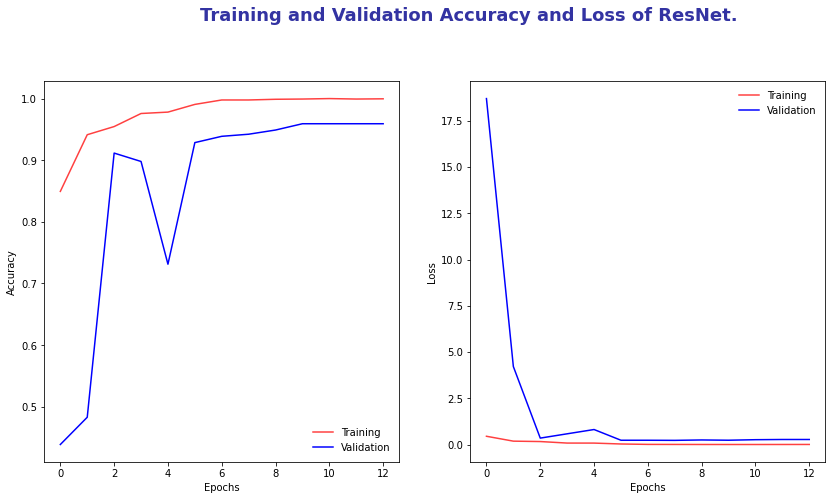

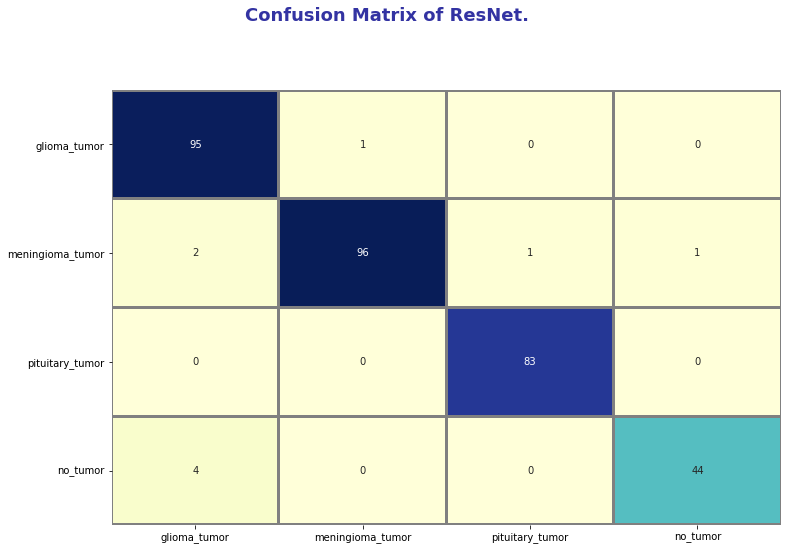

In [13]:
train(model_name=model_r,save_name='ResNet.h5',epoch=100,name='ResNet',X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)

## EfficientNet

In [14]:
eff = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))

In [15]:
model_e=layers(pretrained_model=eff)

In [16]:
model_e.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8487
Epoch 00001: val_accuracy improved from -inf to 0.85034, saving model to effnet.h5
83/83 [==============================] - 82s 986ms/step - loss: 0.4194 - accuracy: 0.8487 - val_loss: 0.4672 - val_accuracy: 0.8503
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9376
Epoch 00002: val_accuracy improved from 0.85034 to 0.89116, saving model to effnet.h5
83/83 [==============================] - 81s 973ms/step - loss: 0.1781 - accuracy: 0.9376 - val_loss: 0.4514 - val_accuracy: 0.8912
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9572
Epoch 00003: val_accuracy did not improve from 0.89116
83/83 [==============================] - 80s 964ms/step - loss: 0.1245 - accuracy: 0.9572 - val_loss: 0.4943 - val_accuracy: 0.8469
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9682


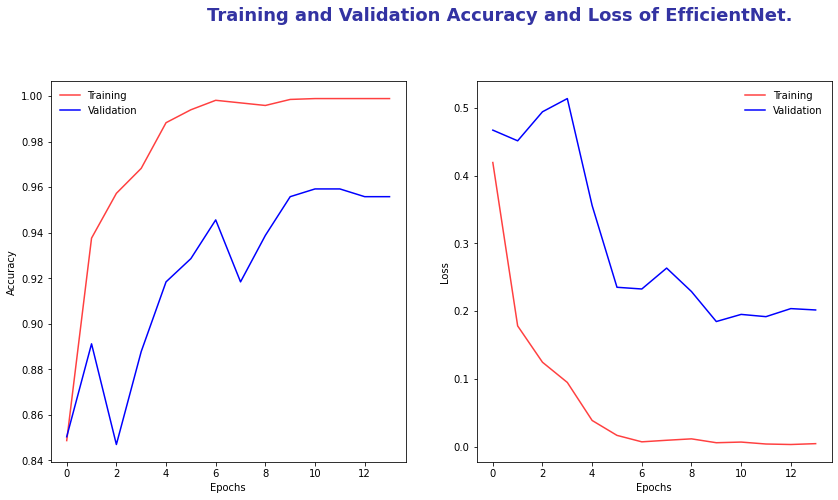

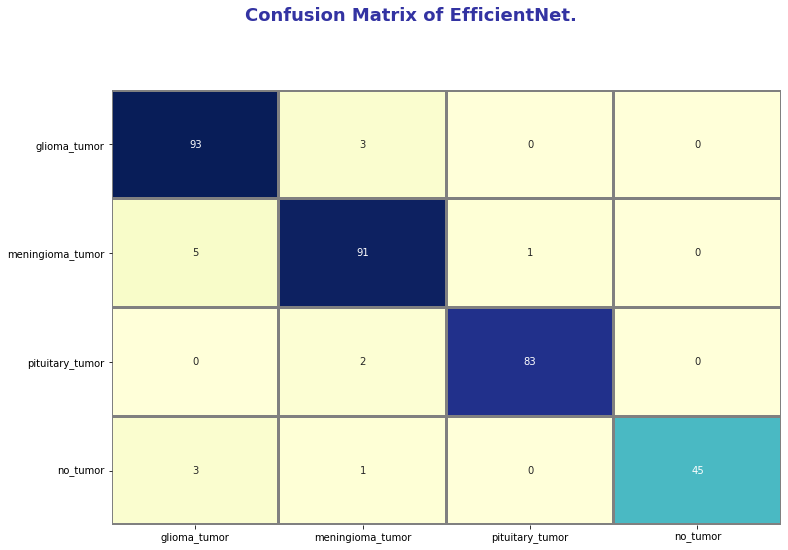

In [17]:
train(model_name=model_e,save_name='effnet.h5',epoch=100,name='EfficientNet',X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)

**<center>Submitted by: Sandnyit Pathare**
**<center>URN: 6667774**
**<center>email: sp01570@surrey.ac.uk**
        
    